In [1]:
import sys 
sys.path.append("..")
from src.dataset import Dataset
import pandas as pd
import os
from definitions import get_synthetic_splits


In [2]:

r'$\bf{Bold}$ Title'
# nice_dataset_names = {"adult": r"$\textbf{Adult}$" +" dataset", "german": r"$\textbf{German credit}$" +" dataset", "dutch": r"$\textbf{Dutch census}$" +" dataset", "credit": r"$\textbf{Credit card clients}$" +" dataset"}
nice_dataset_names = {"adult": "Adult" +" dataset"}
sampling_methods = ['class', 'class_protected', 'protected', 'same_class']
sampling_methods_names = ['class', 'class \& protected', 'protected', 'class (ratio)']

protected_attributes = ["race"]



In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Function to format y-axis labels
def format_ytick(x, pos):
    if x >= 1000:
        return '{:1.0f}k'.format(x*1e-3)
    else:
        return '{:1.0f}'.format(x)


datasets = list(nice_dataset_names.keys())


def get_fad(datasets, sampling_methods, protected_attributes = ["sex"]):

    final_augmented_dataset_plots_all =[]
    for dd, dataset in enumerate(datasets):
        
        dataset_generator = Dataset(dataset)
        target = dataset_generator.target
        
        split_dfs, additional_sizes = dataset_generator.split_population(dataset_generator.original_dataframe, protected_attributes)

        # Apply the formatter to the y-axis
        # Assuming you have two different DataFrames: df1 and df2
        # Replace df1 and df2 with your actual DataFrame names
        final_augmented_dataset_plots = []
        sampling_methods = ['class', 'class_protected', 'protected', 'same_class']
        sampling_methods_names = ['class', 'class & protected', 'protected', 'class (same)']

        for sampling_method in sampling_methods:
            augmented_dfs, augmented_dfs_plot = get_synthetic_splits(dataset_generator, split_dfs, generative_method="gaussian_copula", generative_seed=0, return_plot=True, sampling_method=sampling_method)
            final_augmented_dataset = pd.concat(augmented_dfs)
            final_augmented_dataset_plot = pd.concat(augmented_dfs_plot)
            final_augmented_dataset_plot['target_method'] = final_augmented_dataset_plot[target].astype(str) + ' (' + final_augmented_dataset_plot['method'].astype(str) + ')'
            final_augmented_dataset_plots.append(final_augmented_dataset_plot)

        final_augmented_dataset_plots_all.append(final_augmented_dataset_plots)
    return final_augmented_dataset_plots_all



In [4]:
final_augmented_dataset_plots_all = get_fad(datasets, sampling_methods, protected_attributes=protected_attributes)

Dataset adult_fnlwgt_educational-num has ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'] categorical and ['age', 'capital-gain', 'capital-loss', 'hours-per-week'] numerical columns.
		 Synthetic samples gaussian_copula


/home/panagiotou/Desktop/FairAugment/util/../src/dataset.py:646: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for attr_values, indices in dataframe.groupby(protected_attributes).groups.items():


		 Synthetic samples gaussian_copula
		 Synthetic samples gaussian_copula
		 Synthetic samples gaussian_copula


In [5]:
final_augmented_dataset_plots_all[0][0][protected_attributes[0]]

3        Other
4        Other
6        Other
10       Other
11       Other
         ...  
18484    White
18485    White
18486    White
18487    White
18488    White
Name: race, Length: 68028, dtype: object

Dataset adult_fnlwgt_educational-num has ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'] categorical and ['age', 'capital-gain', 'capital-loss', 'hours-per-week'] numerical columns.


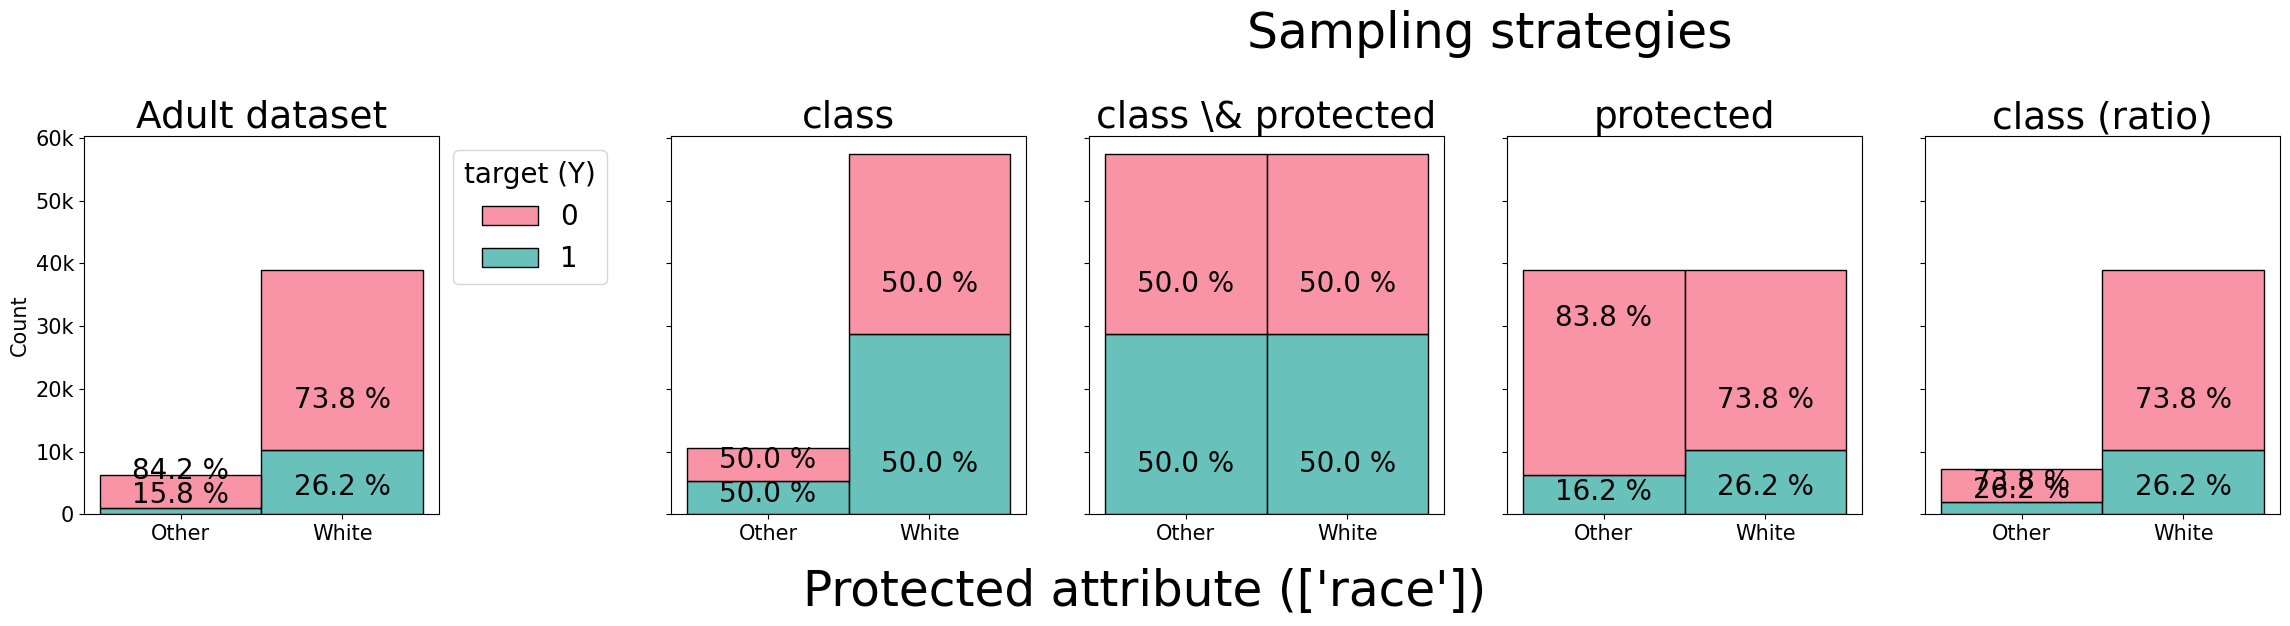

In [12]:
def create_plot(datasets, sampling_methods, final_augmented_dataset_plots_all, sampling_methods_names, min_under, protected_attributes=["sex"]):
    fig, axess = plt.subplots(nrows=len(datasets), ncols=2 + len(sampling_methods), figsize=(23, 6), sharex='col', sharey='row', gridspec_kw={'width_ratios': [1, 0.3] + [1]*len(sampling_methods)})
    for dd, dataset in enumerate(datasets):
        
        dataset_generator = Dataset(dataset)
        target = dataset_generator.target
        axes = axess
        
        final_augmented_dataset_plots = final_augmented_dataset_plots_all[dd]
        # Set up the plot with two subplots in two columns

        # Define the palette using Seaborn's color palette generator
        palette = sns.color_palette("husl", 2)  # Using 'husl' palette with 2 colors

        gender_order = ['Female', 'Male']  # Adjust as per your actual category order

        dfo = dataset_generator.original_dataframe
        # dfo['sex'] = dfo['sex'].replace({'female': 'Female', 'male': 'Male'})
        dfo = dfo.rename(columns={target: 'target (Y)'})

        # Plot for df1
        sns.histplot(data=dfo, x=protected_attributes[0], hue='target (Y)', palette=palette, multiple="stack", ax=axes[0], discrete = True)
        axes[0].set_title(nice_dataset_names[dataset], fontsize=27)
        axes[0].set_ylabel('Count', fontsize=15)

        axes[0].set_xlabel('')



        sns.move_legend(axes[0], "upper left", fontsize=20, title_fontsize=20, bbox_to_anchor=(1, 1))




        for i, final_data in enumerate(final_augmented_dataset_plots):  
            # final_data['sex'] = final_data['sex'].replace({'female': 'Female', 'male': 'Male'})
            final_data = final_data.rename(columns={target: 'target (Y)'})


            sns.histplot(data=final_data, x=protected_attributes[0], hue='target (Y)', palette=palette, multiple="stack", ax=axes[i+2], discrete = True, legend=False)
            axes[i+2].set_title('{}'.format(sampling_methods_names[i]), fontsize=27)
            axes[i+2].set_xlabel('')

        # Adjust layout

        axes[1].axis('off') 

        for ak, ax in enumerate(axes):
            for kk, bar in enumerate(ax.patches):
                # Find the total height of bars for the current x-coordinate
                total_height = sum(p.get_height() for p in ax.patches if p.get_x() == bar.get_x())
                # Calculate the percentage
                percentage = (bar.get_height() / total_height) * 100
                # Annotate the bar with the percentage
                if bar.get_height() < min_under[dd]:
                    ax.annotate(f'{percentage:.1f} %', 
                                xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2 + 0.4*bar.get_height()),
                                xytext=(0, 0),  # 3 points vertical offset
                                textcoords="offset points",
                                ha='center', va='bottom', fontsize=20)
                else:

                    if ("credit" in dataset and kk==0 and ak==0) or ("credit" in dataset and kk==0 and ak==5) or ("german" in dataset and kk==2 and ak==0)or ("german" in dataset and kk==2 and ak==5):
                        ax.annotate(f'{percentage:.1f} %', 
                            xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2 - 0.4*bar.get_height()),
                            xytext=(0, 0),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=20)

                    elif ("adult" in dataset and kk==2 and ak==0) or ("adult" in dataset and kk==2 and ak==4):
                        ax.annotate(f'{percentage:.1f} %', 
                            xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2 + 0.2*bar.get_height()),
                            xytext=(0, 0),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=20)
                    else:
                        ax.annotate(f'{percentage:.1f} %', 
                            xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2 - 0.3*bar.get_height()),
                            xytext=(0, 0),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=20)
                                
        axes[0].yaxis.set_major_formatter(ticker.FuncFormatter(format_ytick))

        fig.supxlabel("Protected attribute ({})".format(protected_attributes), fontsize=35)

        fig.suptitle("Sampling strategies", fontsize=35, y=1.02, x=0.65)  # Set super title


        for ii, ax in enumerate(axes):
            ax.tick_params(axis='x', labelsize=15)  # Set font size for x-axis
            ax.tick_params(axis='y', labelsize=15)  # Set font size for y-axis


    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    # plt.savefig("../results/sampling_methods_all.jpg".format(dataset), dpi=300, bbox_inches="tight", pad_inches=0)

    plt.show()
# from matplotlib import rc
# rc('text', usetex=True)



min_under = [5000, 0, 0, 0]
create_plot(datasets, sampling_methods, final_augmented_dataset_plots_all, sampling_methods_names, min_under, protected_attributes=protected_attributes)